In [1]:
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
!pip install torch-summary

In [3]:
from torchsummary import summary

# Seed

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
set_seed(719)

# Dataset and Dataloader

In [7]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()
        
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size), 
                transforms.ToTensor()
            ])
            
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl
            
    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[rand_idx])
        
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        
        return photo_img, monet_img
    
    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [8]:
img_ds = ImageDataset('../input/gan-getting-started/monet_jpg/', 
                      '../input/gan-getting-started/photo_jpg/')

In [9]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

In [10]:
photo_img, monet_img = next(iter(img_dl))

In [11]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

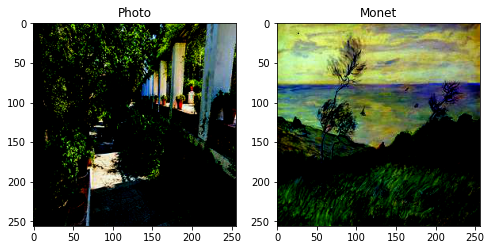

In [12]:
f = plt.figure(figsize=(8, 8))

f.add_subplot(1, 2, 1)
plt.title('Photo')
#photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

f.add_subplot(1, 2, 2)
plt.title('Monet')
#monet_img = unnorm(monet_img)
plt.imshow(monet_img[0].permute(1, 2, 0))

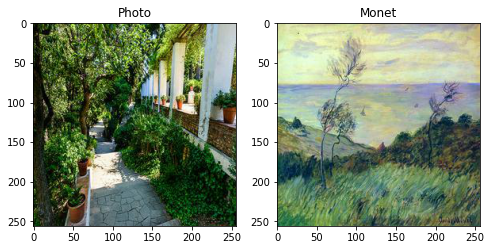

In [13]:
f = plt.figure(figsize=(8, 8))

f.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

f.add_subplot(1, 2, 2)
plt.title('Monet')
monet_img = unnorm(monet_img)
plt.imshow(monet_img[0].permute(1, 2, 0))

# Checkpoints

In [14]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

In [15]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

# Model 

In [16]:
def upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):     
    conv_trans = nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1)
    norm = nn.InstanceNorm2d(out_ch)
    dropout = nn.Dropout(dropout_ratio)
    activation = nn.ReLU()
    
    
    if use_dropout: return nn.Sequential(conv_trans, norm, dropout, activation)
    else: return nn.Sequential(conv_trans, norm, activation)

In [17]:
def convlayer(in_ch, out_ch, k_size, stride, zero_pad=True, pad=1, 
              leaky_relu=True, inst_norm = True):
    if zero_pad:
        conv = nn.Conv2d(in_ch, out_ch, k_size, stride, padding=pad, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, k_size, stride, padding=0, bias=True)
        
    if leaky_relu:
        activation = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        activation = nn.ReLU()
       
    if inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else: 
        norm = nn.BatchNorm2d(out_ch)
    
    return nn.Sequential(conv, norm, activation)

In [18]:
class resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(convlayer(in_features, in_features, 3, 1, 
                                 leaky_relu=False, inst_norm=False, zero_pad=False))
        
        if use_dropout: 
            layers.append(nn.Dropout(dropout_ratio))
            
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.BatchNorm2d(in_features))
        
        self.res = nn.Sequential(*layers)
        
    def forward(self, x):
        return x + self.res(x)

In [19]:
class generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=9):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(convlayer(in_ch, 64, 7, stride=1, 
                               zero_pad=False, leaky_relu=False, inst_norm=True))
        model.append(convlayer(64, 128, 3, stride=2, leaky_relu=False))
        model.append(convlayer(128, 256, 3, stride=2, leaky_relu=False))
        
        for i in range(num_res_blocks):
            model.append(resblock(256))
            
        model.append(upsample(256, 128))
        model.append(upsample(128, 64))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=3))
        model.append(nn.Tanh())
        
        self.gen = nn.Sequential(*model)
        
    def forward(self, x):
        return self.gen(x)

In [20]:
class discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        for i in range(1, num_layers):
            in_ch_ = 64 * 2**(i-1)
            out_ch_ = 2 * in_ch_
            
            if i == num_layers:
                model.append(convlayer(in_ch_, out_ch_, 4, stride=1))
            else:
                model.append(convlayer(in_ch_, out_ch_, 4, stride=2))
                
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        
        self.disc = nn.Sequential(*model)
        
    def forward(self, x):
        return self.disc(x)

# Other helper functions

In [21]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            # SELF NOTE: IF THE LAYER HAS A WEIGHT AND 
            # SELF NOTE: IS EITHER A CONVOLUTIONAL LAYER OR A LINEAR LAYER, INITIALIZE THE WEIGHT
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            # SELF NOTE: IF THE LAYER IS A BATCHNORM LAYER, INITIALIZE THE WEIGHT
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [22]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [23]:
class sample_imgs(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [24]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [25]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

# Build GAN

In [26]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        
        self.gen_mtp = generator(in_ch, out_ch)
        self.gen_ptm = generator(in_ch, out_ch)
        
        self.disc_m = discriminator(in_ch)
        self.disc_p = discriminator(in_ch)
        
        self.init_models()
        
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        self.adam_disc = torch.optim.Adam(itertools.chain(self.disc_m.parameters(), self.disc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        
        self.sample_monet = sample_imgs()
        self.sample_photo = sample_imgs()
        
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        disc_lr = lr_sched(self.decay_epoch, self.epochs)
        
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.disc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_disc, disc_lr.step)
       
        self.gen_stats = AvgStats()
        self.disc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.disc_m)
        init_weights(self.disc_p)
        
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.disc_m = self.disc_m.to(self.device)
        self.disc_p = self.disc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_disc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                
                update_req_grad([self.disc_m, self.disc_p], False) # SELF NOTE: FREEZE TRAINING FOR DISCRIMINATOR
                self.adam_gen.zero_grad() # SELF NOTE: LOSS.BACKWARD() ACCUMULATES GRADIENTS WITH EACH 
                                          # SELF NOTE: ITERATION SO NEED TO ZERO IT BEFORE CALCULATION

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycle_monet = self.gen_ptm(fake_photo)
                cycle_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycle_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycle_photo, photo_img) * self.lmbda

                monet_disc = self.disc_m(fake_monet)
                photo_disc = self.disc_p(fake_photo)

                real = torch.ones(monet_disc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_disc, real)
                adv_loss_photo = self.mse_loss(photo_disc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward() # SELF NOTE: FINDS THE GRADIENT DLOSS/DX
                self.adam_gen.step() # SELF NOTE: UPDATES X += -LR * DLOSS/DX

                # Forward pass through Discriminator
                update_req_grad([self.disc_m, self.disc_p], True) # SELF NOTE: ALLOW TRAINING FOR DISCRIMINATOR
                self.adam_disc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_disc_real = self.disc_m(monet_img)
                monet_disc_fake = self.disc_m(fake_monet)
                
                photo_disc_real = self.disc_p(photo_img)
                photo_disc_fake = self.disc_p(fake_photo)

                real = torch.ones(monet_disc_real.size()).to(self.device)
                fake = torch.zeros(monet_disc_fake.size()).to(self.device)

                # Discriminator losses
                monet_disc_real_loss = self.mse_loss(monet_disc_real, real)
                monet_disc_fake_loss = self.mse_loss(monet_disc_fake, fake)
                
                photo_disc_real_loss = self.mse_loss(photo_disc_real, real)
                photo_disc_fake_loss = self.mse_loss(photo_disc_fake, fake)

                monet_disc_loss = (monet_disc_real_loss + monet_disc_fake_loss) / 2
                photo_disc_loss = (photo_disc_real_loss + photo_disc_fake_loss) / 2
                
                total_disc_loss = monet_disc_loss + photo_disc_loss
                avg_disc_loss += total_disc_loss.item()

                # Backward
                monet_disc_loss.backward()
                photo_disc_loss.backward()
                self.adam_disc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), disc_loss=total_disc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_mtp': gan.gen_mtp.state_dict(),
                'gen_ptm': gan.gen_ptm.state_dict(),
                'disc_m': gan.disc_m.state_dict(),
                'disc_p': gan.disc_p.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_disc': gan.adam_disc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_disc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.disc_stats.append(avg_disc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_disc_loss))
      
            self.gen_lr_sched.step()
            self.disc_lr_sched.step()

In [27]:
gan = CycleGAN(3, 3, 5, device)

In [28]:
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'disc_m': gan.disc_m.state_dict(),
    'disc_p': gan.disc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_disc': gan.adam_disc.state_dict()
}

save_checkpoint(save_dict, 'init.ckpt')

In [29]:
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:11.965929 | Discriminator Loss:0.883230


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:10.178649 | Discriminator Loss:0.427620


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:9.658073 | Discriminator Loss:0.387605


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:9.164005 | Discriminator Loss:0.317209


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:8.420157 | Discriminator Loss:0.283546


# Convert to Monet

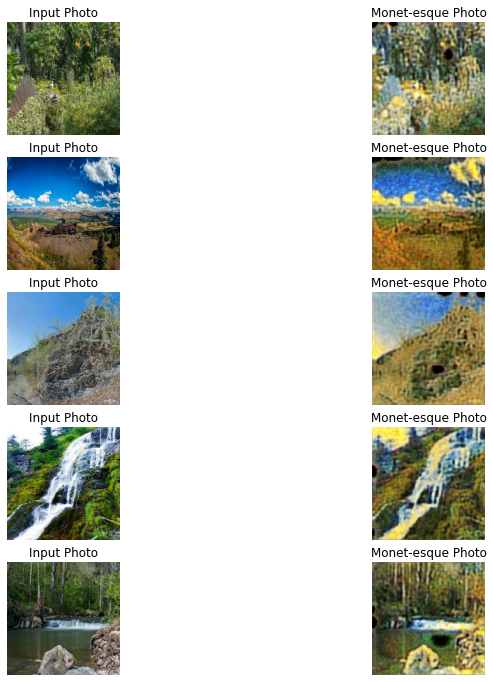

In [30]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i in range(5):
    photo_img, _ = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_monet = unnorm(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()